In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import ContrastiveCorInfoMaxHopfieldSparse
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.FashionMNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.FashionMNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
architecture = [784, 500, 10]

beta = 1
lambda_ = 0.99999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([0.35, 0.23]), 'fb': np.array([np.nan, 0.06])}

STlambda_lr_list = [1e-6, 0.01]
sparse_layers = [1, 2]
neural_lr_start = 0.045
neural_lr_stop = 0.001
neural_lr_rule = "divide_by_slow_loop_index"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 10
neural_dynamic_iterations_free = 20
hopfield_g = 0.2
use_random_sign_beta = True
use_three_phase = False
weight_decay = False

model = ContrastiveCorInfoMaxHopfieldSparse(architecture = architecture, lambda_ = lambda_, 
                                            epsilon = epsilon, activation = activation, sparse_layers = sparse_layers)

In [5]:
_ = evaluateContrastiveCorInfoMaxHopfieldSparse(model, train_loader, hopfield_g,
                                                neural_lr_start, neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.06395


In [6]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 30

for epoch_ in range(n_epochs):
    if epoch_ < 15:
        lr = {'ff' : lr_start['ff'] * (0.95)**epoch_, 'fb' : lr_start['fb'] * (0.95)**epoch_}
    else:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, train_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, test_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))
    print("Free Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_free)[-1] / np.array(model.layerwise_backward_corinfo_list_free)[-1]))
    print("Nudged Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_nudged)[-1] / np.array(model.layerwise_backward_corinfo_list_nudged)[-1]))

3000it [01:57, 25.48it/s]
0it [00:00, ?it/s]

Epoch : 1, Train Accuracy : 0.8297833333333333, Test Accuracy : 0.8183
Free Information ratio: [0.0381586]
Nudged Information ratio: [0.03815824]


3000it [01:57, 25.54it/s]
0it [00:00, ?it/s]

Epoch : 2, Train Accuracy : 0.8502333333333333, Test Accuracy : 0.8394
Free Information ratio: [0.07427232]
Nudged Information ratio: [0.07427063]


3000it [01:58, 25.36it/s]
0it [00:00, ?it/s]

Epoch : 3, Train Accuracy : 0.8556833333333334, Test Accuracy : 0.8401
Free Information ratio: [0.05574233]
Nudged Information ratio: [0.05573996]


3000it [01:57, 25.57it/s]
0it [00:00, ?it/s]

Epoch : 4, Train Accuracy : 0.8545, Test Accuracy : 0.8377
Free Information ratio: [0.06897083]
Nudged Information ratio: [0.06896787]


3000it [01:57, 25.55it/s]
0it [00:00, ?it/s]

Epoch : 5, Train Accuracy : 0.8708166666666667, Test Accuracy : 0.8506
Free Information ratio: [0.07593432]
Nudged Information ratio: [0.07593052]


3000it [01:57, 25.53it/s]
0it [00:00, ?it/s]

Epoch : 6, Train Accuracy : 0.8763666666666666, Test Accuracy : 0.8592
Free Information ratio: [0.084808]
Nudged Information ratio: [0.08480319]


3000it [01:57, 25.57it/s]
0it [00:00, ?it/s]

Epoch : 7, Train Accuracy : 0.8821333333333333, Test Accuracy : 0.8611
Free Information ratio: [0.07654467]
Nudged Information ratio: [0.07653984]


3000it [01:57, 25.58it/s]
0it [00:00, ?it/s]

Epoch : 8, Train Accuracy : 0.8875, Test Accuracy : 0.8654
Free Information ratio: [0.06287328]
Nudged Information ratio: [0.06286753]


3000it [01:57, 25.56it/s]
0it [00:00, ?it/s]

Epoch : 9, Train Accuracy : 0.8875666666666666, Test Accuracy : 0.866
Free Information ratio: [0.06914543]
Nudged Information ratio: [0.06913987]


3000it [01:57, 25.57it/s]
0it [00:00, ?it/s]

Epoch : 10, Train Accuracy : 0.8886166666666667, Test Accuracy : 0.8661
Free Information ratio: [0.06278931]
Nudged Information ratio: [0.062783]


3000it [01:21, 37.01it/s]
1it [00:00,  5.56it/s]

Epoch : 11, Train Accuracy : 0.8855166666666666, Test Accuracy : 0.8638
Free Information ratio: [0.06478117]
Nudged Information ratio: [0.06477425]


3000it [00:57, 52.50it/s]
1it [00:00,  5.83it/s]

Epoch : 12, Train Accuracy : 0.8936666666666667, Test Accuracy : 0.8727
Free Information ratio: [0.04938397]
Nudged Information ratio: [0.04937647]


3000it [00:57, 51.82it/s]
1it [00:00,  5.68it/s]

Epoch : 13, Train Accuracy : 0.89725, Test Accuracy : 0.8725
Free Information ratio: [0.04933912]
Nudged Information ratio: [0.04933305]


3000it [00:57, 52.50it/s]
1it [00:00,  5.26it/s]

Epoch : 14, Train Accuracy : 0.8964, Test Accuracy : 0.8705
Free Information ratio: [0.03876349]
Nudged Information ratio: [0.03875831]


3000it [00:57, 52.42it/s]
1it [00:00,  5.91it/s]

Epoch : 15, Train Accuracy : 0.8966, Test Accuracy : 0.8692
Free Information ratio: [0.03158133]
Nudged Information ratio: [0.03157494]


3000it [00:57, 52.44it/s]
1it [00:00,  5.12it/s]

Epoch : 16, Train Accuracy : 0.9022166666666667, Test Accuracy : 0.8775
Free Information ratio: [0.03098111]
Nudged Information ratio: [0.03097624]


3000it [01:14, 40.26it/s]
1it [00:00,  5.38it/s]

Epoch : 17, Train Accuracy : 0.9044166666666666, Test Accuracy : 0.8757
Free Information ratio: [0.03654466]
Nudged Information ratio: [0.03653768]


3000it [00:57, 52.54it/s]
1it [00:00,  5.88it/s]

Epoch : 18, Train Accuracy : 0.9037666666666667, Test Accuracy : 0.8764
Free Information ratio: [0.02695741]
Nudged Information ratio: [0.02695088]


3000it [00:57, 52.57it/s]
1it [00:00,  5.94it/s]

Epoch : 19, Train Accuracy : 0.9005666666666666, Test Accuracy : 0.8744
Free Information ratio: [0.02493512]
Nudged Information ratio: [0.02492923]


3000it [00:58, 51.60it/s]
1it [00:00,  5.23it/s]

Epoch : 20, Train Accuracy : 0.8968, Test Accuracy : 0.871
Free Information ratio: [0.01681301]
Nudged Information ratio: [0.01680881]


3000it [00:57, 52.42it/s]
1it [00:00,  5.85it/s]

Epoch : 21, Train Accuracy : 0.9062833333333333, Test Accuracy : 0.8764
Free Information ratio: [0.02406762]
Nudged Information ratio: [0.02406071]


3000it [00:58, 51.02it/s]
1it [00:00,  5.91it/s]

Epoch : 22, Train Accuracy : 0.9049833333333334, Test Accuracy : 0.877
Free Information ratio: [0.02367143]
Nudged Information ratio: [0.02366486]


3000it [00:57, 52.61it/s]
0it [00:00, ?it/s]

Epoch : 23, Train Accuracy : 0.9073666666666667, Test Accuracy : 0.88
Free Information ratio: [0.02287168]
Nudged Information ratio: [0.02286616]


3000it [01:05, 46.05it/s]
0it [00:00, ?it/s]

Epoch : 24, Train Accuracy : 0.9090833333333334, Test Accuracy : 0.878
Free Information ratio: [0.01933859]
Nudged Information ratio: [0.01933195]


3000it [01:04, 46.16it/s]
1it [00:00,  5.63it/s]

Epoch : 25, Train Accuracy : 0.9082166666666667, Test Accuracy : 0.8801
Free Information ratio: [0.02039393]
Nudged Information ratio: [0.02038716]


3000it [00:57, 52.49it/s]
1it [00:00,  5.36it/s]

Epoch : 26, Train Accuracy : 0.90915, Test Accuracy : 0.8796
Free Information ratio: [0.02068129]
Nudged Information ratio: [0.02067409]


3000it [00:57, 52.47it/s]
1it [00:00,  5.86it/s]

Epoch : 27, Train Accuracy : 0.9053666666666667, Test Accuracy : 0.8785
Free Information ratio: [0.01483143]
Nudged Information ratio: [0.01482609]


3000it [00:57, 52.45it/s]
1it [00:00,  5.74it/s]

Epoch : 28, Train Accuracy : 0.9075333333333333, Test Accuracy : 0.8758
Free Information ratio: [0.01290802]
Nudged Information ratio: [0.01290275]


3000it [00:57, 52.17it/s]
1it [00:00,  5.53it/s]

Epoch : 29, Train Accuracy : 0.9107833333333333, Test Accuracy : 0.8794
Free Information ratio: [0.01631431]
Nudged Information ratio: [0.01630753]


3000it [00:58, 51.57it/s]


Epoch : 30, Train Accuracy : 0.91135, Test Accuracy : 0.8802
Free Information ratio: [0.01550505]
Nudged Information ratio: [0.01549797]


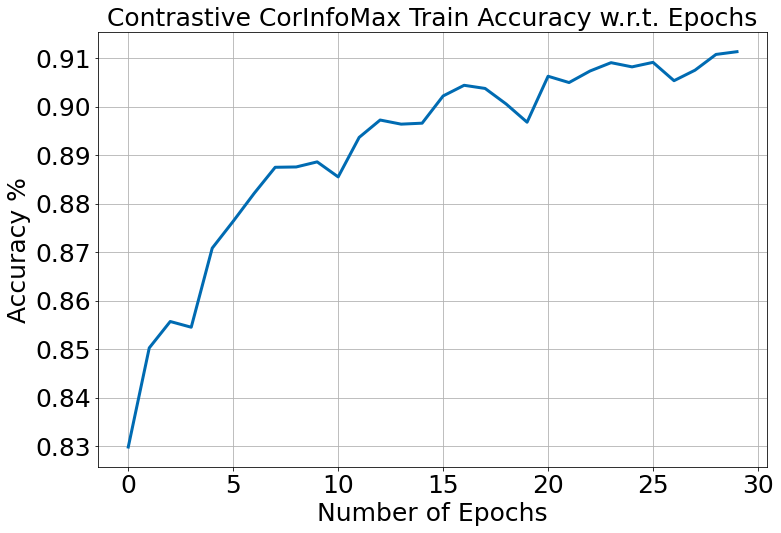

In [7]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

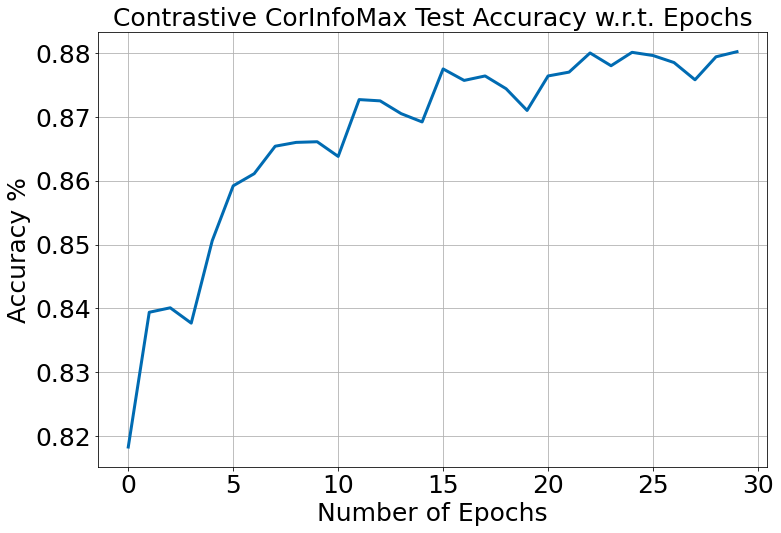

In [8]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)